<a id="plan"></a>

## Exploratory Data Analysis of Microsoft GUIDE dataset

-  [Observe the dataset](#shape)
-  [Incident grade analysis](#ig)
-  [Incident grade over time analysis](#igtime)
-  [Event specifics analysis](#igeventdata)
-  [Companies & Detectors analysis](#compdet)
-  [Geo traffic analysis](#geodata)
-  [MITRE techniques analysis](#mitre)

[Bottom](#bottom)

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns 
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud
import pandas as pd
from pathlib import Path
from collections import Counter
from itertools import combinations
import src.helponeda as analysis

In [2]:
data_path = Path().resolve() / 'data'
df = pd.read_feather(data_path / 'ready2eda.feather')

<a id="shape"></a>

### Observe the dataset

[Back to top](#plan)

In [3]:
df.shape

(9450394, 34)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9450394 entries, 0 to 9516836
Data columns (total 34 columns):
 #   Column                     Dtype   
---  ------                     -----   
 0   ThreatFamily               category
 1   RegistryValueName          int16   
 2   ApplicationName            int16   
 3   AccountName                int32   
 4   AlertTitle                 int32   
 5   EntityType                 category
 6   Category                   category
 7   MitreTechniques            category
 8   IncidentGrade              category
 9   OrgId                      int16   
 10  DetectorId                 int16   
 11  OSFamily                   int8    
 12  OSVersion                  int8    
 13  AntispamDirection          category
 14  CountryCode                int8    
 15  State                      int16   
 16  City                       int16   
 17  AntispamDirection_na       bool    
 18  ThreatFamily_na            bool    
 19  MitreTechniques_na        

In [5]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ThreatFamily,9450394,1746,NoFamily,9376881,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RegistryValueName,9450394.0,NaN,NaN,NaN,634.732626,12.625244,0.0,635.0,635.0,635.0,635.0
ApplicationName,9450394.0,NaN,NaN,NaN,3342.245495,512.070568,0.0,3421.0,3421.0,3421.0,3421.0
AccountName,9450394.0,NaN,NaN,NaN,358415.112471,173492.390492,0.0,453297.0,453297.0,453297.0,453297.0
AlertTitle,9450394.0,NaN,NaN,NaN,2779.993793,10920.959515,0.0,2.0,11.0,173.0,113174.0
EntityType,9450394,33,Ip,2175106,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Category,9450394,20,InitialAccess,4267755,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MitreTechniques,9450394,1186,Unknown,5420922,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IncidentGrade,9450394,3,BenignPositive,4116515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OrgId,9450394.0,NaN,NaN,NaN,178.689866,376.800374,0.0,9.0,44.0,170.0,6144.0


<a id="ig"></a>

### Incident grade values ratio
For us it is interesting to know how balanced the target is. We will use the knowledge to decide whether or not we need to adjust weights in the model

[Back to top](#plan)

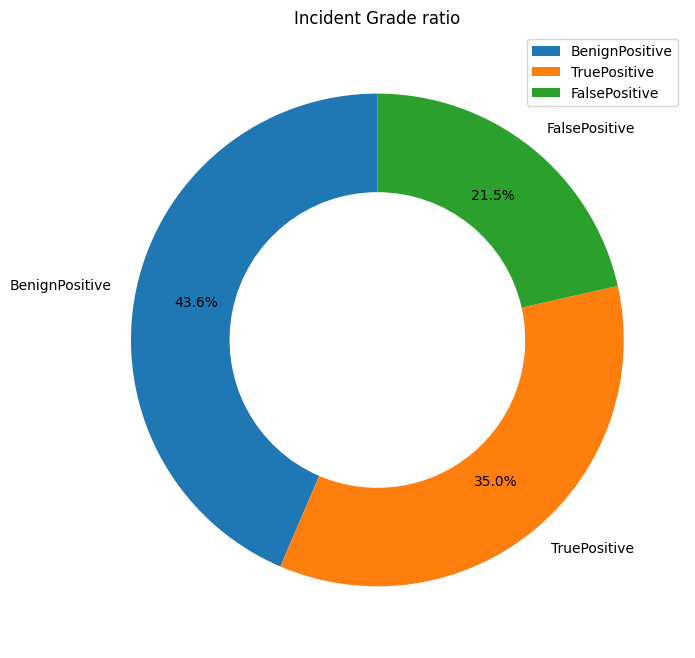

In [6]:
target_labels = df['IncidentGrade'].value_counts()

fig, ax = plt.subplots(figsize=(8,8))
wedges, texts, autotexts = ax.pie(
  target_labels,
  labels = target_labels.index,
  autopct="%1.1f%%",
  startangle=90,
  pctdistance=0.75,
  wedgeprops = dict(width = 0.4)
)

ax.set(aspect = 'equal')
plt.title('Incident Grade ratio')
plt.legend(loc = 'upper right')
plt.show()

Conclusion: the target classes are not balanced. I need to adjust weights

<a id="igtime"></a>

### Incident grades over time

[Back to top](#plan)

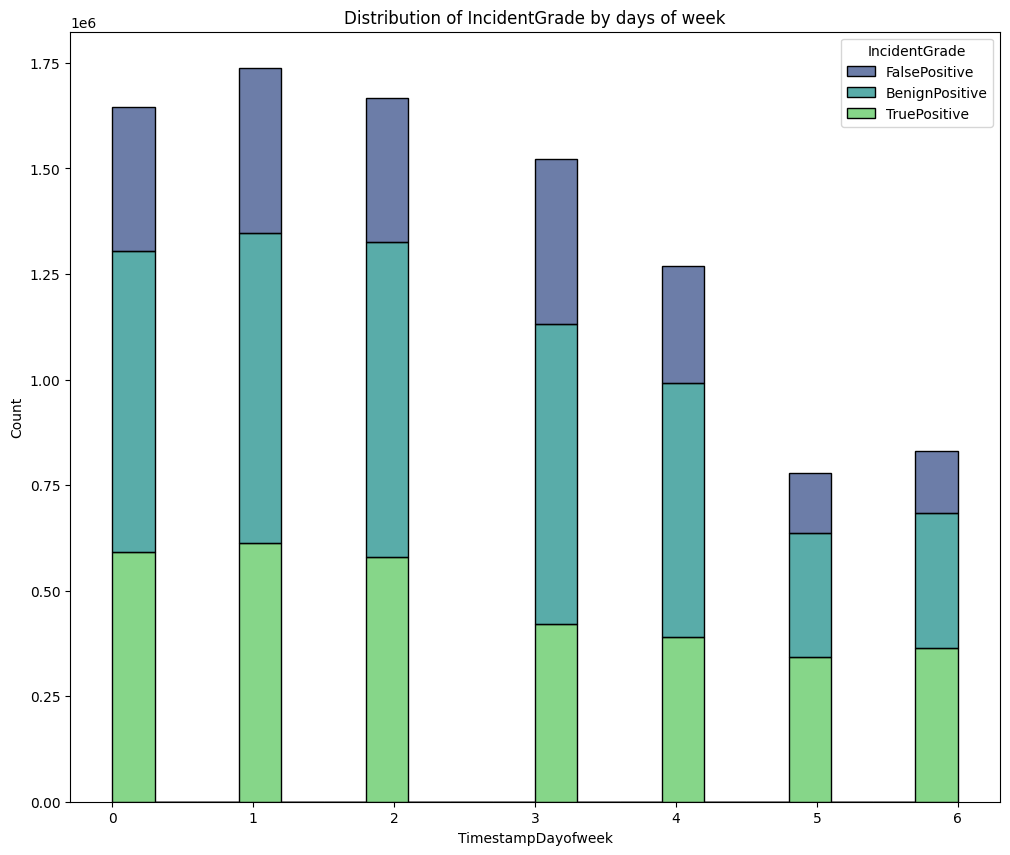

In [7]:
plt.figure(figsize=(12, 10))
sns.histplot(data=df, x='TimestampDayofweek',
            bins=20, hue="IncidentGrade", palette="viridis",
            multiple="stack")
plt.title(f'Distribution of IncidentGrade by days of week')
plt.show()

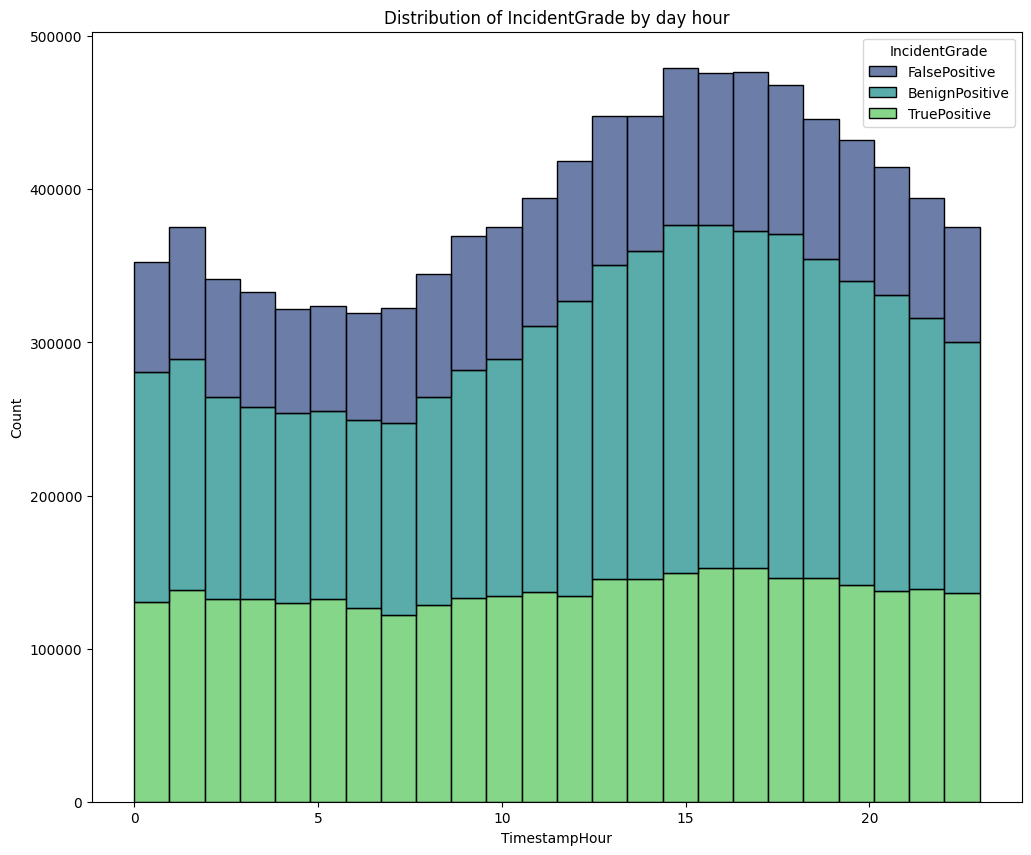

In [8]:
plt.figure(figsize=(12, 10))
sns.histplot(data=df, x='TimestampHour',
            bins=24, hue="IncidentGrade", palette="viridis",
            multiple="stack")
plt.title(f'Distribution of IncidentGrade by day hour')
plt.show()

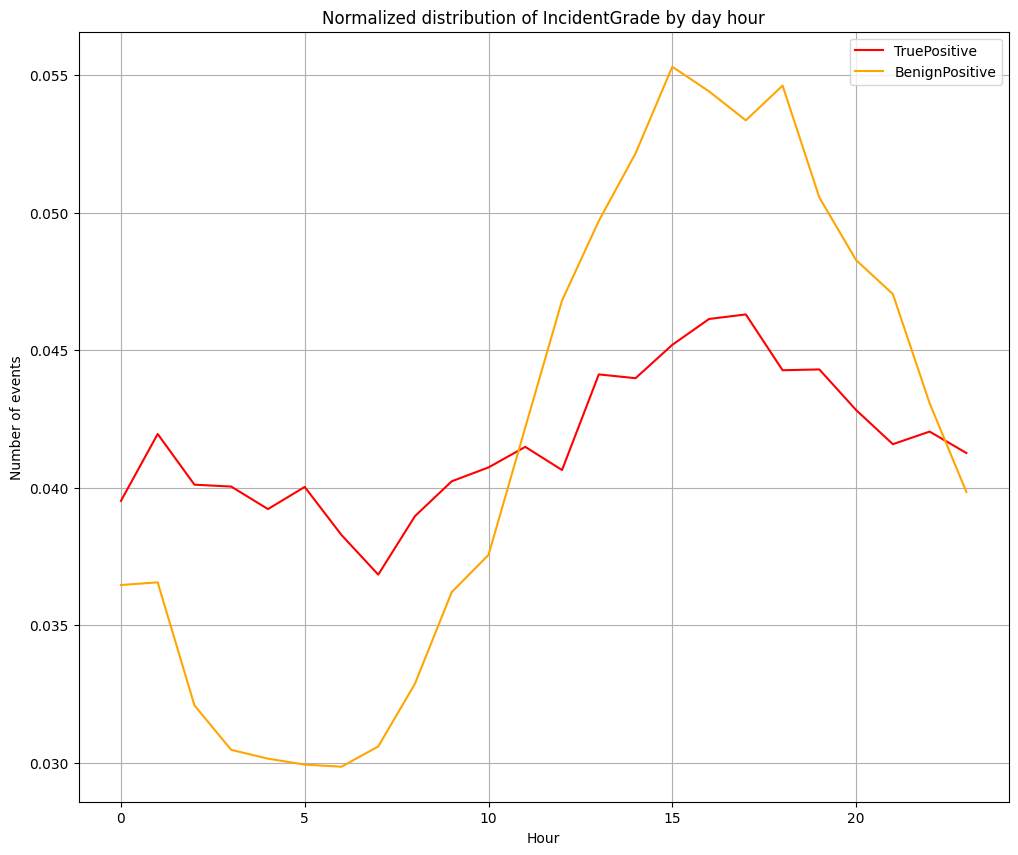

In [9]:
hours = sorted(df.TimestampHour.unique())
tp_by_hour = df.groupby('TimestampHour').agg({'IncidentGrade': lambda x: x[x == 'TruePositive'].shape[0]}) / df[df.IncidentGrade == 'TruePositive'].shape[0]
bp_by_hour = df.groupby('TimestampHour').agg({'IncidentGrade': lambda x: x[x == 'BenignPositive'].shape[0]}) / df[df.IncidentGrade == 'BenignPositive'].shape[0]
plt.figure(figsize=(12, 10))
plt.plot(hours, tp_by_hour, color='red', label='TruePositive')
plt.plot(hours, bp_by_hour, color='orange', label='BenignPositive')
plt.title(f'Normalized distribution of IncidentGrade by day hour')
plt.xlabel('Hour')
plt.ylabel('Number of events')
plt.legend()
plt.grid(True)
plt.show()

Interesting remark: from the line plot we can see that BP and TP tend to go in the same direction. Taking in account that BP can be an admin login on a website or another action related to the working staff, I can conclude that there are more attacks when BP events occur more(probably meaning an extending number of admins due to bigger net traffic, that is the moment for an attack). The above can be also interpreted as some detector prediction limitation.

In [10]:
fig = analysis.sankeyBool(df, 'TimestampIsWeekend', 'IncidentGrade', 'Weekday',
    'Weekend', df.IncidentGrade.unique(),
    ['rgba(60,140,200,0.9)', 'rgba(220,110,60,0.9)'],
    ['rgba(220,70,70,0.95)', 'rgba(220, 255,10,0.95)', 'rgba(88,184,86,0.95)']
)
fig.show()

After this graph I had a thought that the proportion TP/FP is not the same for working days and days off. After further analysis (two graphs below) I can conclude that it must be a visual misinterpretation, though it could be fine to make some tests on these groups, which is definitely not the purpose of our EDA

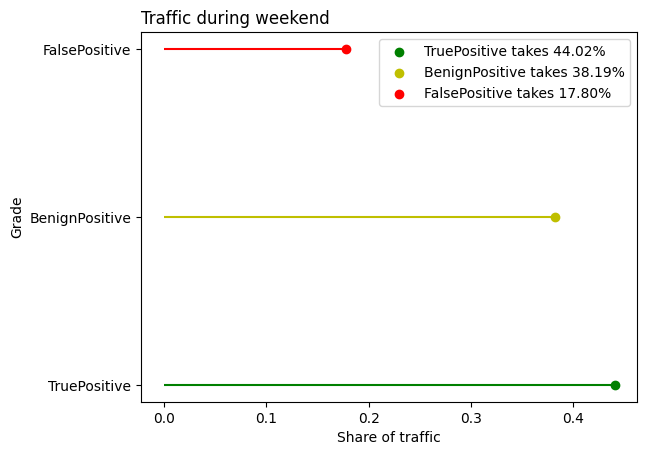

In [11]:
target_labels = df[df.TimestampIsWeekend == True]['IncidentGrade'].value_counts()
target_labels /= target_labels.sum()
colors = ['g', 'y', 'r']

rang = range(target_labels.shape[0])

for i in rang:
  val = target_labels.iloc[i]
  plt.hlines(y=i, xmin=0,xmax=val, color=colors[i])
  plt.scatter(x=val, y=i, marker="o", color=colors[i], label=f'{target_labels.index[i]} takes {val:.2%}')

plt.yticks(rang, target_labels.index)
plt.title("Traffic during weekend", loc='left')
plt.xlabel('Share of traffic')
plt.ylabel('Grade')
plt.legend()
plt.show()

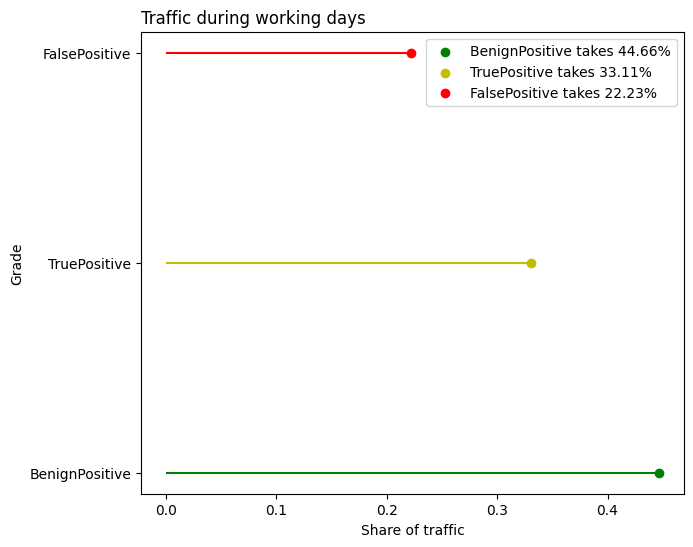

In [12]:
target_labels = df[df.TimestampIsWeekend == False]['IncidentGrade'].value_counts()
target_labels /= target_labels.sum()
colors = ['g', 'y', 'r']

rang = range(target_labels.shape[0])
plt.figure(figsize=(7, 6))

for i in rang:
  val = target_labels.iloc[i]
  plt.hlines(y=i, xmin=0,xmax=val, color=colors[i])
  plt.scatter(x=val, y=i, marker="o", color=colors[i], label=f'{target_labels.index[i]} takes {val:.2%}')

plt.yticks(rang, target_labels.index)
plt.title("Traffic during working days", loc='left')
plt.xlabel('Share of traffic')
plt.ylabel('Grade')
plt.legend()
plt.show()

In [13]:
agg_time_traffic = df.groupby('TimestampPartOfDay', observed=False)['IncidentGrade'].value_counts().reset_index(name='count')

pivot = agg_time_traffic.pivot(index='IncidentGrade', columns='TimestampPartOfDay', values='count').fillna(0)

fig = go.Figure()
for col in pivot.columns:
    fig.add_trace(
        go.Scatterpolar(
            r=pivot[col].values,
            theta=pivot.index.tolist(),
            name=str(col)
        )
    )

fig.update_layout(
    title_text='Incident grade by part of day distribution',
    polar=dict(
        angularaxis=dict(rotation=90, direction="clockwise"),
        radialaxis=dict(visible=True)
    ),
    margin=dict(l=0, r=0, t=40, b=40),
    height=600
)
fig.show()

<a id="igeventdata"></a>

### Analyzing event specifics in relation with the incident grade

[Back to top](#plan)

In [14]:
agg_os_grade = (
    df.groupby(['OSFamily', 'IncidentGrade'], observed=False)
    .size()
    .reset_index(name='count')
)

agg_os_grade['OSFamily'] = agg_os_grade['OSFamily'].astype(str)
agg_os_grade['IncidentGrade'] = agg_os_grade['IncidentGrade'].astype(str)

fig = px.treemap(
    agg_os_grade,
    path=['OSFamily', 'IncidentGrade'],
    values='count',
    color='IncidentGrade',
    color_discrete_sequence=px.colors.qualitative.Set3
)

fig.update_layout(
    title_text='Incident grade by OS family (0-5 are unique families)'
)
fig.show()

To the right bottom we can see other OS families. They are hardly observable (look like not working pixels on the monitor), so let us plot them separately

In [15]:
df_wo_os0_5 = df[df.OSFamily.isin([1,2,3,4])]

agg_os_grade = (
    df_wo_os0_5.groupby(['OSFamily', 'IncidentGrade'], observed=False)
    .size()
    .reset_index(name='count')
)

agg_os_grade['OSFamily'] = agg_os_grade['OSFamily'].astype(str)
agg_os_grade['IncidentGrade'] = agg_os_grade['IncidentGrade'].astype(str)

fig = px.treemap(
    agg_os_grade,
    path=['OSFamily', 'IncidentGrade'],
    values='count',
    color='IncidentGrade',
    color_discrete_sequence=px.colors.qualitative.Set3
)
fig.update_layout(
    title_text='Incident grade by OS family (without families 0, 5)'
)
fig.show()

Finally we can observe those little groups: we see two OS families. In fact, there are two more, but they are so small that I did not dig deeper (after I observed how many instances those groups have) and decided to leave them unseen (you will understand why from the graph below)

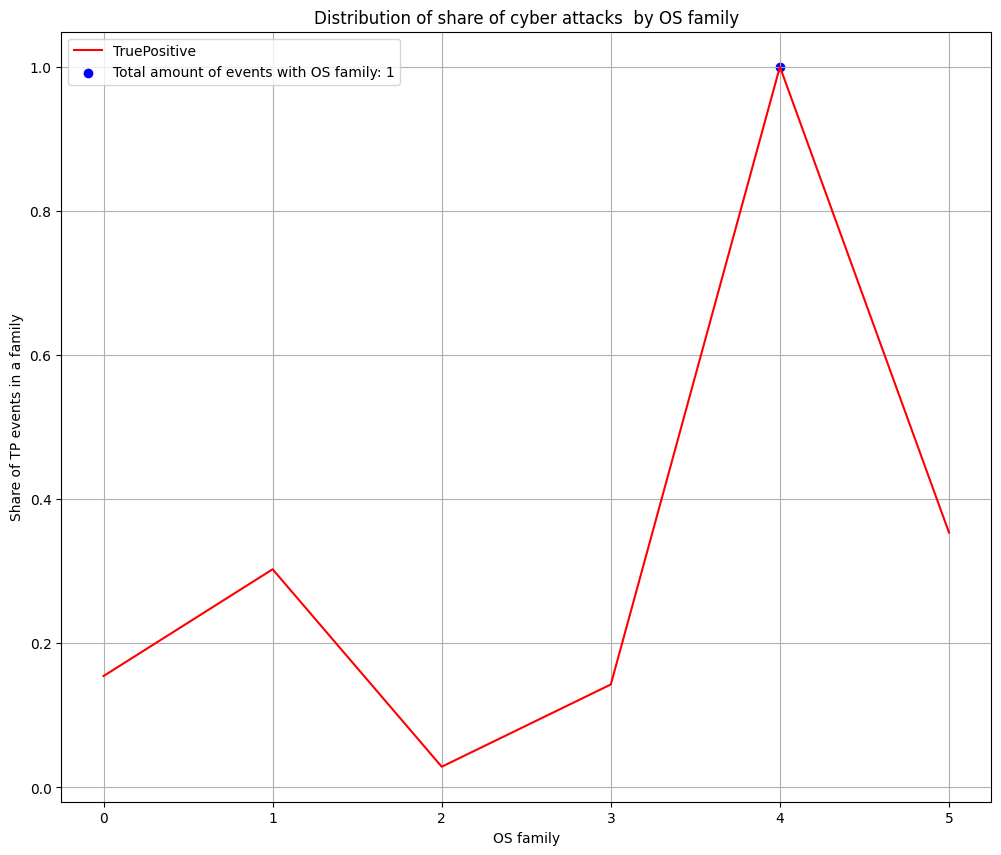

In [16]:
osfam_attacks = (df.groupby('OSFamily').agg({'IncidentGrade': lambda x: x[x == 'TruePositive'].shape[0]}) / df.groupby('OSFamily').agg({'IncidentGrade': 'count'})).reset_index()
plt.figure(figsize=(12, 10))
plt.plot(osfam_attacks.OSFamily, osfam_attacks.IncidentGrade, color='red', label='TruePositive')

osf_ratio_1 = osfam_attacks[osfam_attacks.IncidentGrade == osfam_attacks.IncidentGrade.max()]
plt.scatter(osf_ratio_1.OSFamily, osf_ratio_1.IncidentGrade,
  color='b',
  label=f'Total amount of events with OS family: {df[df.OSFamily == osf_ratio_1.OSFamily.iloc[0]].shape[0]}'
)

plt.title(f'Distribution of share of cyber attacks  by OS family')
plt.xlabel('OS family')
plt.ylabel('Share of TP events in a family')
plt.legend()
plt.grid(True)
plt.show()

100% of TP for family 4 is misleading: in fact, there is only one observation of a device with this OS family type from 13 million events

Let us now observe threat families, but firstly we will drop NoFamily category:

In [17]:
print(f'{df[df.ThreatFamily == 'NoFamily'].shape[0] / df.shape[0]:.2%}')

99.22%


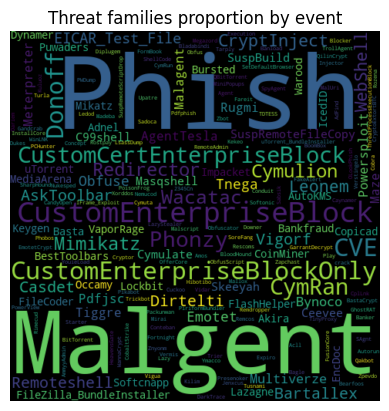

In [18]:
text = ' '.join(i for i in df[df.ThreatFamily != 'NoFamily'].ThreatFamily)

wordcloud = WordCloud(width=480, height=480, margin=0).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Threat families proportion by event')
plt.show()

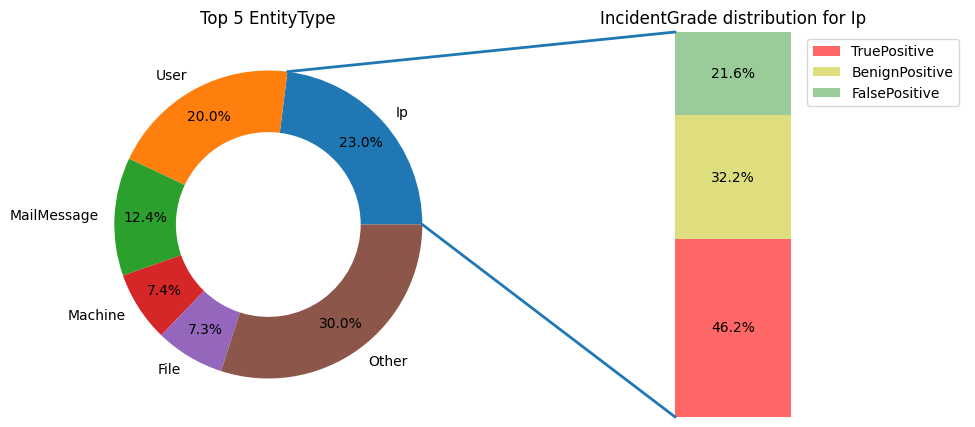

In [19]:
plt = analysis.pieWithBar(5, df, 'EntityType', 'Ip', 'IncidentGrade',
                        ['r', 'y', 'g'])
plt.show()

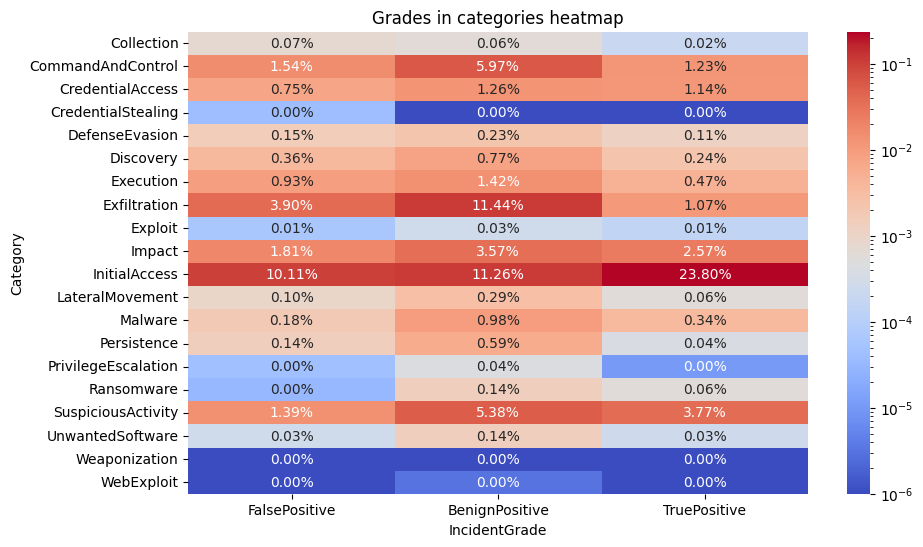

In [20]:
pivot = pd.crosstab(df.Category, df.IncidentGrade, normalize='all') + 1e-16

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='.2%', cmap=sns.color_palette("coolwarm", as_cmap=True), norm=LogNorm(vmin=1e-6, vmax=pivot.values.max()))
plt.title('Grades in categories heatmap')
plt.show()

<a id="compdet"></a>

### Most attacked companies and best detectors

[Back to top](#plan)

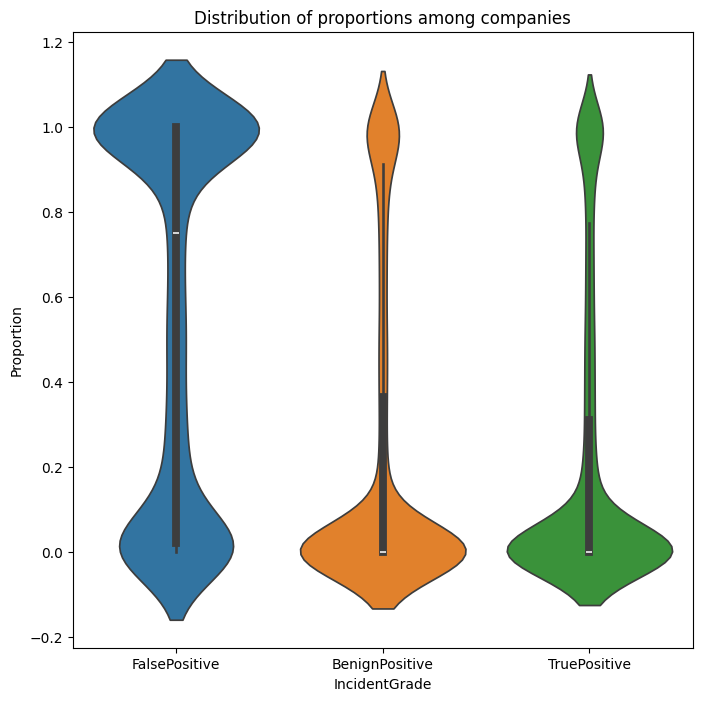

In [21]:
prop = df.groupby('OrgId')['IncidentGrade'].value_counts(normalize=True).unstack(fill_value=0)

plt.figure(figsize=(8,8))
sns.violinplot(data=prop)
plt.title('Distribution of proportions among companies')
plt.ylabel('Proportion')
plt.show()

In [22]:
prop[prop.FalsePositive == 1]

IncidentGrade,FalsePositive,BenignPositive,TruePositive
OrgId,,,
37,1.0,0.0,0.0
60,1.0,0.0,0.0
88,1.0,0.0,0.0
140,1.0,0.0,0.0
184,1.0,0.0,0.0
...,...,...,...
6117,1.0,0.0,0.0
6121,1.0,0.0,0.0
6123,1.0,0.0,0.0


In [23]:
prop[prop.FalsePositive == 0]

IncidentGrade,FalsePositive,BenignPositive,TruePositive
OrgId,,,
10,0.0,0.002711,0.997289
14,0.0,0.143742,0.856258
21,0.0,1.000000,0.000000
22,0.0,0.000000,1.000000
25,0.0,1.000000,0.000000
...,...,...,...
6118,0.0,0.000000,1.000000
6120,0.0,1.000000,0.000000
6129,0.0,1.000000,0.000000


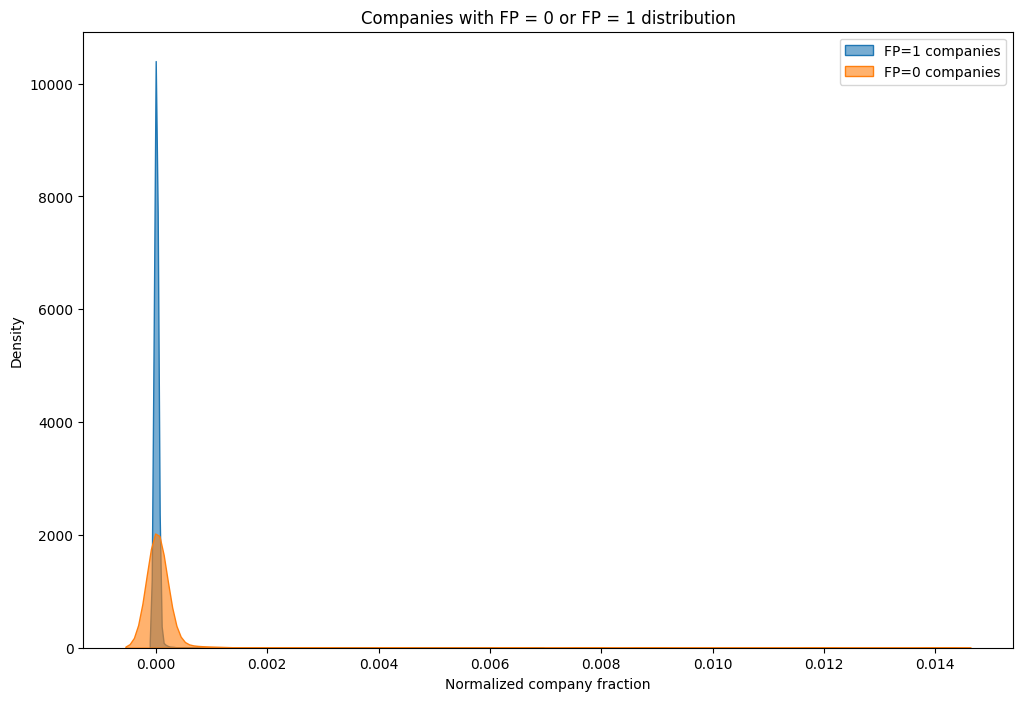

In [24]:
org_counts = df['OrgId'].value_counts() / df.shape[0]

fp1_values = org_counts.reindex(prop[prop['FalsePositive'] == 1].index).fillna(0).values
fp0_values = org_counts.reindex(prop[prop['FalsePositive'] == 0].index).fillna(0).values

plt.figure(figsize=(12,8))

sns.kdeplot(fp1_values, fill=True, alpha=0.6, label='FP=1 companies')
sns.kdeplot(fp0_values, fill=True, alpha=0.6, label='FP=0 companies')

plt.title('Companies with FP = 0 or FP = 1 distribution')
plt.xlabel("Normalized company fraction")
plt.legend()
plt.show()

In [25]:
detectors = df.DetectorId.value_counts()
frequent_detectors = detectors[detectors >= 100]
det_prop = df[df.DetectorId.isin(frequent_detectors)].groupby(
  'DetectorId'
  )['IncidentGrade'].value_counts(normalize=True).unstack(fill_value=0)
bad_detectors = det_prop[(det_prop.FalsePositive > 0.4) & (
  det_prop.FalsePositive < 0.6)
]
bad_detectors = bad_detectors.assign(Group='Bad detectors')
bad_detectors

IncidentGrade,FalsePositive,BenignPositive,TruePositive,Group
DetectorId,,,,
107,0.482009,0.231588,0.286403,Bad detectors
114,0.583257,0.399688,0.017055,Bad detectors
170,0.427893,0.572107,0.000000,Bad detectors
182,0.421223,0.379225,0.199553,Bad detectors
190,0.500816,0.420881,0.078303,Bad detectors
199,0.583333,0.416667,0.000000,Bad detectors
204,0.536810,0.255624,0.207566,Bad detectors
219,0.491365,0.212121,0.296514,Bad detectors
225,0.431739,0.174636,0.393624,Bad detectors


In [26]:
good_tp_predictors = det_prop[det_prop.TruePositive > 0.8]
good_tp_predictors = good_tp_predictors.assign(Group='Good detectors')
good_tp_predictors

IncidentGrade,FalsePositive,BenignPositive,TruePositive,Group
DetectorId,,,,
106,0.000000,0.000000,1.000000,Good detectors
109,0.000000,0.000000,1.000000,Good detectors
110,0.055533,0.004783,0.939684,Good detectors
124,0.000000,0.000000,1.000000,Good detectors
127,0.000000,0.000000,1.000000,Good detectors
130,0.000000,0.000000,1.000000,Good detectors
143,0.000000,0.011888,0.988112,Good detectors
148,0.013102,0.030990,0.955908,Good detectors
175,0.000000,0.000000,1.000000,Good detectors


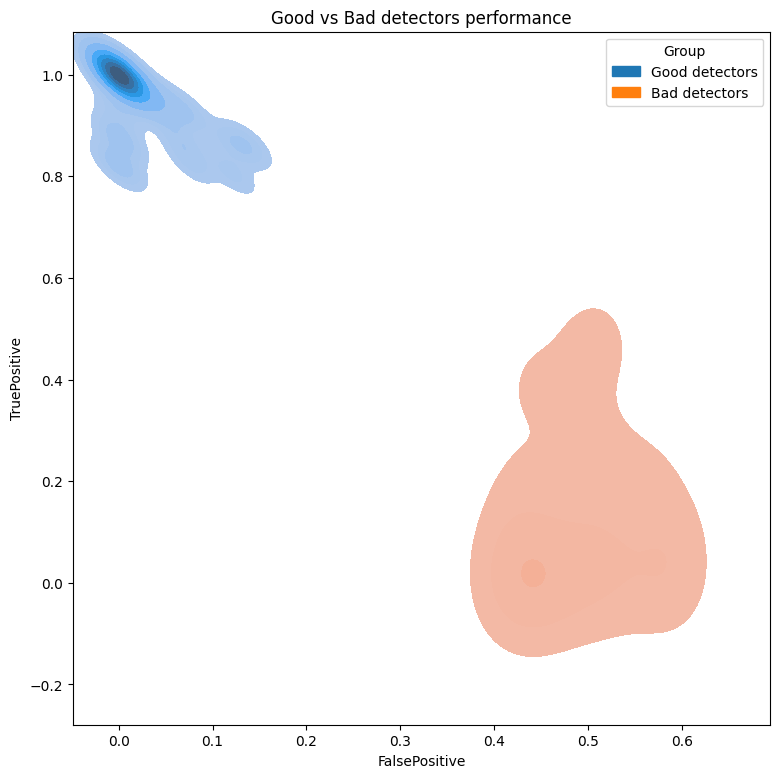

In [27]:
plt.figure(figsize=(9,9))

sns.kdeplot(data=pd.concat([good_tp_predictors, bad_detectors]),
            x="FalsePositive", y="TruePositive",
            fill=True, hue='Group')

plt.title('Good vs Bad detectors performance')
plt.show()

<a id="geodata"></a>

### Traffic from different spots of the globe

[Back to top](#plan)

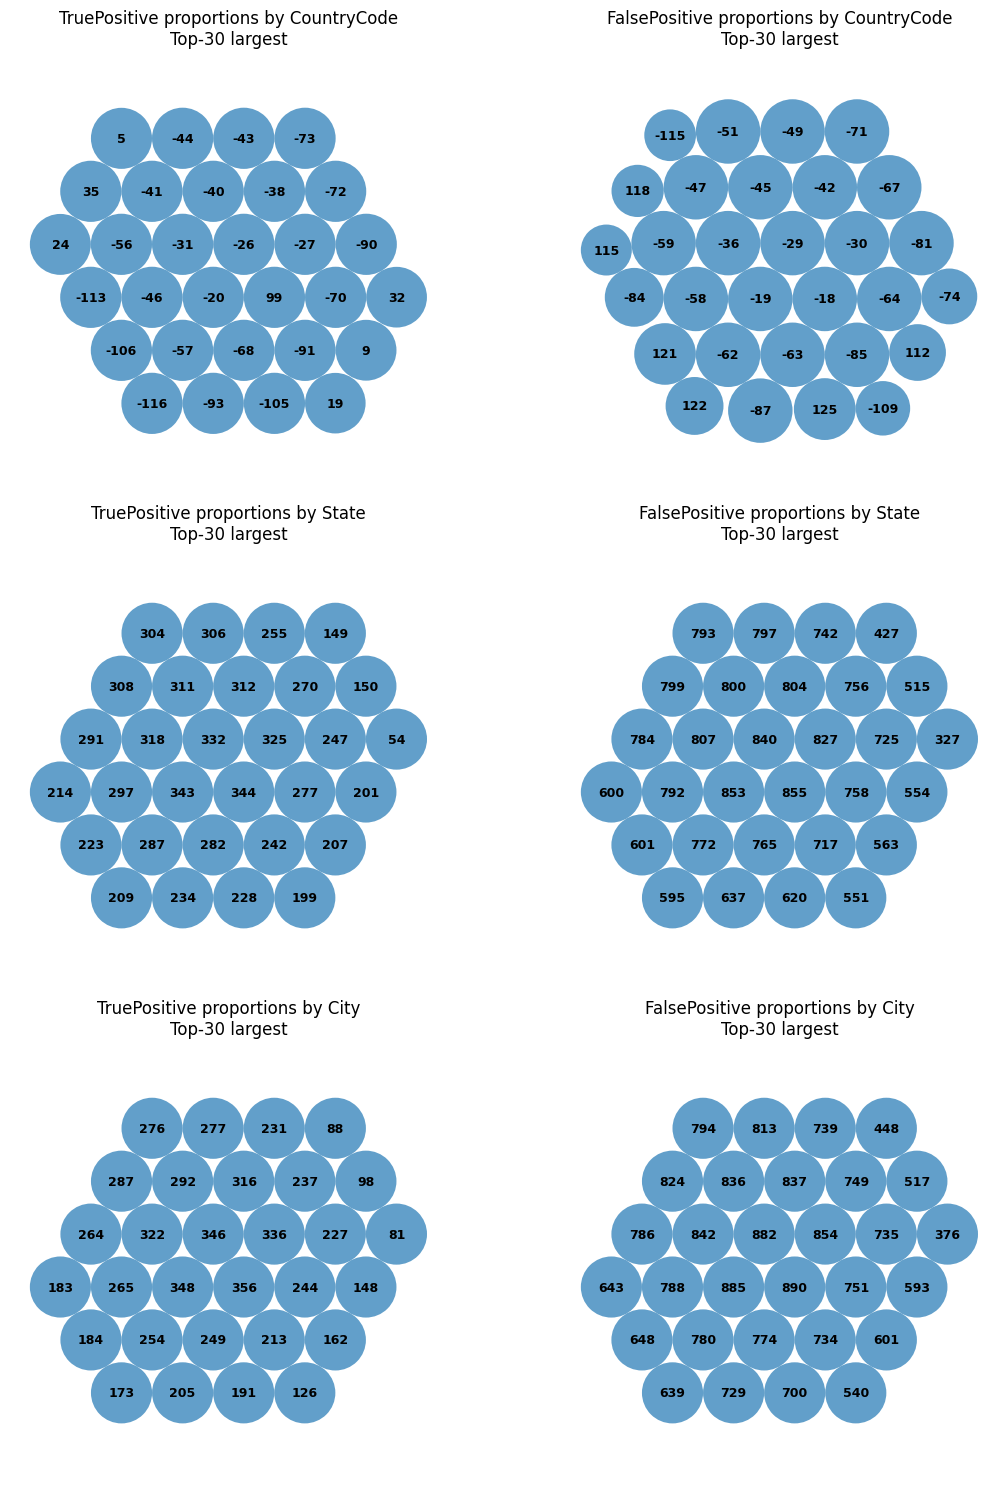

In [28]:
locations = ['CountryCode', 'State', 'City']
column_values = ['TruePositive', 'FalsePositive']
column_idx = 'IncidentGrade'
fig_size = (12,15)
fig, axes = analysis.optimized_circle_packing(df, locations, column_values, column_idx, fig_size, 30)
plt.show()

There is no obvious "place to attack from"

<a id="mitre"></a>

### MITRE techniques

[Back to top](#plan)

In [29]:
s = df['MitreTechniques']
exploded = s.str.split(';').explode().str.strip()
exploded = exploded[exploded != 'Unknown']
top_k = 20
vc = exploded.value_counts()
top = vc.nlargest(top_k) / vc.sum()
top = top.reset_index()

fig = px.pie(top, values='count', names='MitreTechniques', title='Top 20 MITRE techniques')
fig.show()

In [30]:
num_tags = s.str.split(';').apply(lambda lst: len(lst) if 'Unknown' not in lst else 0)
num_tags = num_tags[num_tags != 0].value_counts(
  normalize=True).sort_index().cumsum().reset_index()

fig = px.line(num_tags, x='MitreTechniques', 
    y='proportion', markers=True,
    title='Cumulative share by number of techniques per incident')
fig.update_traces(line_color="#6e6351")
fig.show()

Let us see top MITRE techniques combinations:

In [31]:
def combos_from_row(s_row, k=2):
    items = [t.strip() for t in s_row.split(';') if t.strip()!='']
    if len(items) < k:
        return []
    return list(combinations(sorted(set(items)), k))

pair_counter = Counter()
for row in s[s != 'Unknown']:
    pair_counter.update(combos_from_row(row, k=2))

most_common_pairs = pair_counter.most_common(20)
pd.DataFrame(most_common_pairs, columns=['pair', 'count'])

,pair,count
0,"(T1078, T1078.004)",1343004
1,"(T1110, T1110.003)",105769
2,"(T1110, T1110.001)",105464
3,"(T1110.001, T1110.003)",104035
4,"(T1046, T1071)",63001
5,"(T1087, T1087.002)",59649
6,"(T1078, T1098)",42681
7,"(T1008, T1568)",40643
8,"(T1106, T1559)",38123
9,"(T1059.005, T1106)",37869


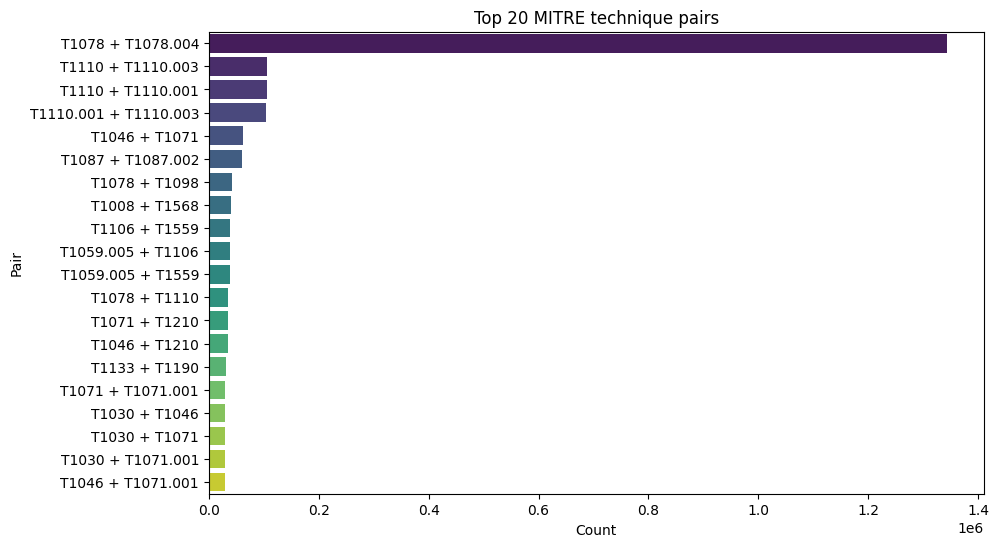

In [32]:
pairs_df = pd.DataFrame(most_common_pairs, columns=['pair','count'])
pairs_df['pair_str'] = pairs_df['pair'].apply(lambda p: ' + '.join(p))

plt.figure(figsize=(10,6))
sns.barplot(x='count', y='pair_str', data=pairs_df, palette='viridis', hue='pair_str')
plt.title('Top 20 MITRE technique pairs')
plt.xlabel('Count')
plt.ylabel('Pair')
plt.show()

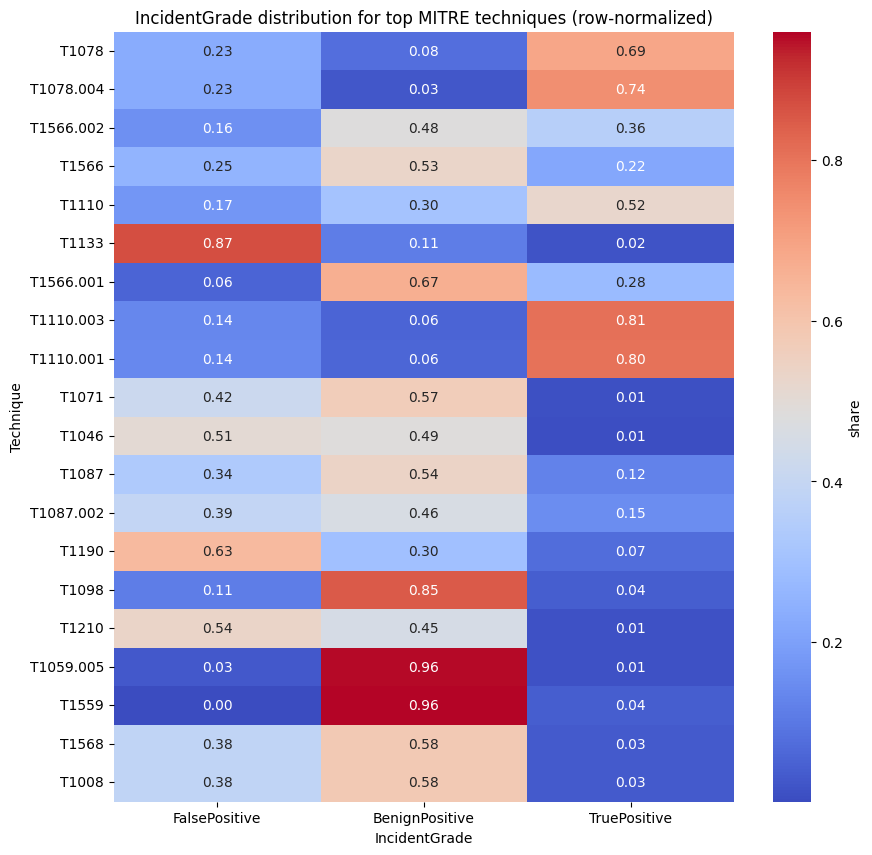

In [33]:
top_n = 20
top_techs = vc.nlargest(top_n).index.tolist()
exploded_df = df[['IncidentGrade']].join(
    s.str.split(';').explode().str.strip().rename('tech')
)
exploded_top = exploded_df[exploded_df['tech'].isin(top_techs)]
ct = pd.crosstab(exploded_top['tech'], exploded_top['IncidentGrade'])
ct = ct.reindex(top_techs)
ct_norm = ct.div(ct.sum(axis=1), axis=0).fillna(0)

plt.figure(figsize=(10,10))
sns.heatmap(ct_norm, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'label':'share'})
plt.title('IncidentGrade distribution for top MITRE techniques (row-normalized)')
plt.xlabel('IncidentGrade')
plt.ylabel('Technique')
plt.show()

In [34]:
fig = analysis.graphFromPairs(100, pair_counter, 1, 200, 900, 900)
fig.show()

<a id="bottom"></a>
[Back to top](#plan)